# Gathering seeing data

I had some discussions with [Miguel Rodríguez Alarcon (IAC)](https://scholar.google.com/citations?user=ySJtt44AAAAJ&hl=es&oi=ao) to discuss the best way to measure and keep track of seeing. 
* He discouraged me from using from using FWHM from images, as this parameter will combine astronomical seeing effects with instrumental seeing. 
* He suggested using the DIMM sensors available throughout the institute. 
* He suggested the idea of observing if variability in DIMM seeing is directly translated into higher FWHM in the images and, therefore, if FWHM can be used for atmospheric-only seeing (i.e. if instrumental seeing is more or less constant).

## Sources of DIMM seeing
* ING - WHTR2D2, accessible via <https://astro.ing.iac.es/seeing/r2d2_data.php>
* TNG - FGC-DIMM, I don't find access to raw data via web.

### Gathering data from R2D2

In [14]:
from aspred.connector import r2d2_seeing
from datetime import datetime
import pandas as pd

initial_date = datetime(2024, 1, 1)
final_date = datetime(2024, 5, 20)

df = r2d2_seeing(initial_date, final_date)

Fetching data from https://astro.ing.iac.es/seeing/r2d2_data.php?date1=2024-01-01&date2=2024-05-20&submit=Submit...
Data retrieved successfully


<Axes: ylabel='Density'>

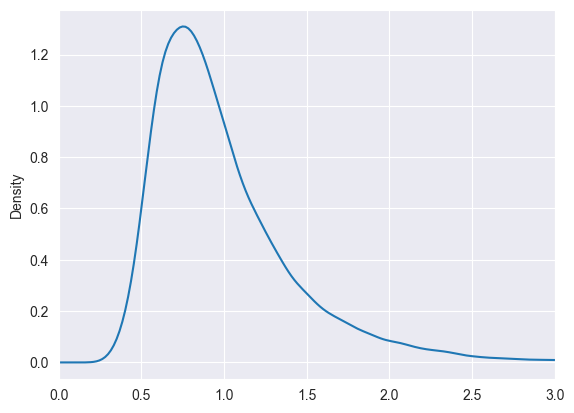

In [15]:
df["Seeing"].plot.kde(xlim=(0, 3))

* Question 1: what's the relation between the calibrated seeing during the photometric pipeline (FWHM), and the DIMM-measured seeing?
* Question 2: how close are TNG and ING seeing measurements?
* Question 3: how can the seeing be predicted from weather data?

## Getting data from LT headers

In [16]:
from aspred.connector import query_from_lt_header
import aspred.utils
import datetime

# Initial date

initial_date_mjd = aspred.utils.datetime_to_mjd(initial_date)
final_date_mjd = aspred.utils.datetime_to_mjd(final_date)

query = """SELECT mjd, AGFWHM, L1SEESEC FROM allkeys WHERE INSTRUME = "IO:O" AND AGFWHM != 0 AND mjd > """ + str(initial_date_mjd) + " AND mjd < " + str(final_date_mjd) + " ORDER BY mjd ASC"
df2 = query_from_lt_header(query)
df2["date"] = df2["mjd"].apply(aspred.utils.mjd_to_datetime)

print(len(df2), "rows")

15899 rows


/Users/fabarzuza/Documents/GitHub/aspred/aspred/connector.py:162: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataframe = pd.read_sql(query, mydb)


In [17]:
df2

,mjd,AGFWHM,L1SEESEC,date
0,60310.005234,2.063,1.37555,2024-01-01 00:07:32.217600
1,60310.005756,2.063,1.13058,2024-01-01 00:08:17.318400
2,60310.006292,2.063,1.51499,2024-01-01 00:09:03.628800
3,60310.007329,2.063,1.45452,2024-01-01 00:10:33.225600
4,60310.007816,2.063,1.22453,2024-01-01 00:11:15.302400
...,...,...,...,...
15894,60424.234737,2.694,999.00000,2024-04-24 05:38:01.276800
15895,60424.240471,2.694,999.00000,2024-04-24 05:46:16.694400
15896,60424.240801,2.694,999.00000,2024-04-24 05:46:45.206400
15897,60424.241203,2.694,999.00000,2024-04-24 05:47:19.939200


In [18]:
# Remove outliers with FWHM > 2
limit = 4
df2 = df2[df2["L1SEESEC"] < limit]
df = df[df["Seeing"] < limit]

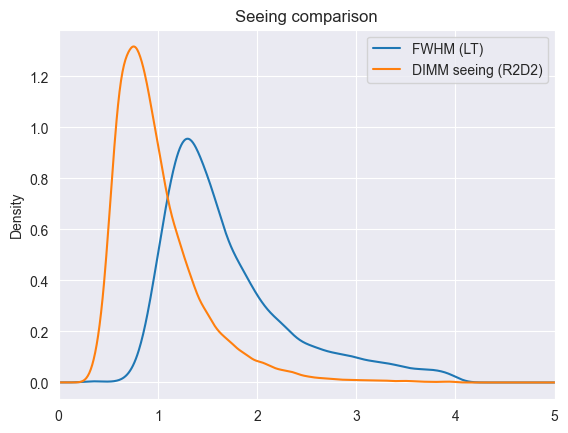

In [19]:
import matplotlib.pyplot as plt
df2["L1SEESEC"].plot.kde(xlim=(0, limit+1), label="FWHM (LT)")
df["Seeing"].plot.kde(xlim=(0, limit+1), label="DIMM seeing (R2D2)")
plt.title("Seeing comparison")
plt.legend()

In [20]:
# Creates a dataframe with 10 minute intervals from the initial date to the last date
date_range = pd.date_range(start=initial_date, end=final_date, freq="10min")

In [21]:
r2d2_list = []
fwhm_list = []
date_list = []

# Loop through the date range and calculate the average seeing (R2D2 and FWHM) for each interval
for i, date in enumerate(date_range):
    print(i, "out of ", len(date_range), end="\r")
    # Add exception for last date
    if i == len(date_range) - 1:
        continue
    # Find r2d2 seeing between this date and the next one
    r2d2_seeing = df[(df["Date"] >= date) & (df["Date"] < date_range[i+1])]["Seeing"]
    # Calculate average seeing for that interval
    r2d2_seeing_mean = r2d2_seeing.mean()
    # Find FWHM between this date and the next one
    fwhm = df2[(df2["date"] >= date) & (df2["date"] < date_range[i+1])]["L1SEESEC"]
    # Calculate average FWHM for that interval
    fwhm_mean = fwhm.mean()
    # Append to the lists
    r2d2_list.append(r2d2_seeing_mean)
    fwhm_list.append(fwhm_mean)
    date_list.append(date)
    

In [22]:
# Create dataframe with lists
df3 = pd.DataFrame({"date": date_list, "r2d2_seeing": r2d2_list, "fwhm_seeing": fwhm_list})
# Remove any rows that contains NaN in either column
df3 = df3.dropna()

Text(0.5, 1.0, 'Seeing comparison')

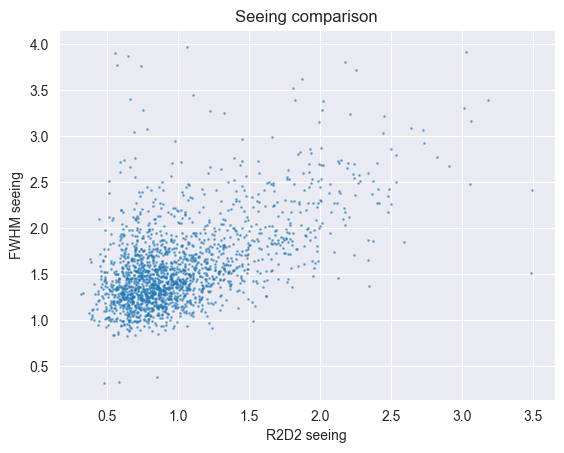

In [23]:
#Plot r2d2 seeing vs FWHM seeing
plt.scatter(df3["r2d2_seeing"], df3["fwhm_seeing"], alpha=0.5, s=1)
plt.xlabel("R2D2 seeing")
plt.ylabel("FWHM seeing")
plt.title("Seeing comparison")

In [24]:
# Find and assess correlation and linear fit
import numpy as np
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(df3["r2d2_seeing"], df3["fwhm_seeing"])
print("Slope:", slope)
print("Intercept:", intercept)
print("R value:", r_value)
print("P value:", p_value)
print("Standard error:", std_err)




Slope: 0.5848235297801809
Intercept: 0.9861094625257849
R value: 0.5547590065425088
P value: 3.0389510135368787e-151
Standard error: 0.020304568681414024


Text(0.5, 1.0, 'Seeing comparison')

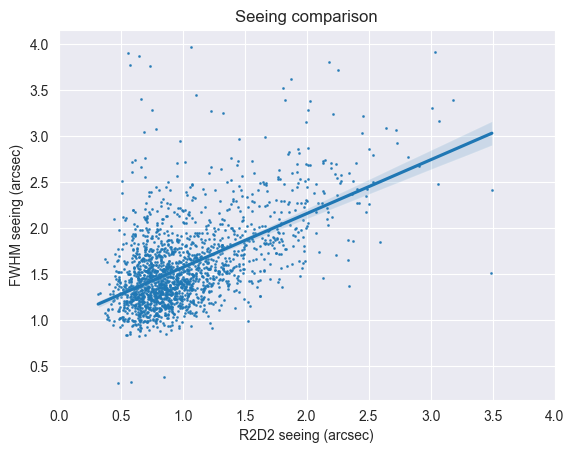

In [27]:
# Plot r2d2 seeing vs FWHM seeing with correlation line
import seaborn as sns
sns.regplot(x="r2d2_seeing", y="fwhm_seeing", data=df3, scatter_kws={"s": 1})
plt.xlim(0,4)
plt.xlabel("R2D2 seeing (arcsec)")
plt.ylabel("FWHM seeing (arcsec)")
plt.title("Seeing comparison")

Conclusion: there is no relation between the seeing measured by the DIMM sensor and the seeing measured by the FWHM in the images.


In [29]:
from fractions import Fraction

In [4]:
def calc_b(a: Fraction)-> Fraction:
    return (Fraction(a/(a-1)))

In [49]:
a = Fraction(2,7)
b = calc_b(a)
print("a =", Fraction(a))
print("b =", Fraction(b))
print("a·b =", a*b)
print("a+b =",a+b)

a = 3/7
b = -3/4
a·b = -9/28
a+b = -9/28


In [69]:
Fraction(5, 4)-Fraction(9, 20)

Fraction(4, 5)

In [72]:
Fraction(2, 5)/Fraction(8,25)

Fraction(5, 4)

In [ ]:
5/4 = 50 / 40 = 